Arm based on this paper:

https://www-spiedigitallibrary-org.tudelft.idm.oclc.org/journals/optical-engineering/volume-57/issue-04/043113/Comparison-of-multihardware-parallel-implementations-for-a-phase-unwrapping-algorithm/10.1117/1.OE.57.4.043113.full

Works also on LS but adds mechanism to minimize impact of residues
with this source:

https://codeocean.com/capsule/2672585/tree/v1

* insert credits
* explenation on implemetation of C code

Still need to insrt some weights based on the paper, to improve results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
sys.path.append(os.path.abspath("..")) 

from scipy.fftpack import dctn, idctn

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

# Optics
lam   = 0.532     # wavelength (µm)

from src.cylinder_phase import cylinder_phase_perp_to_z_3d

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   

# Activate for cylinder geometry

R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrapped_used = phi_wrapped

ARM


In [2]:
import ctypes

dll_path = r"C:\Users\oheymans\odt-thesis\src\ARM\arm.dll"
lib = ctypes.CDLL(dll_path)

# Try to see if any "unwrap" function is in there
for name in dir(lib):
    if "unwrap" in name.lower():
        print(name)

-23.447269053418314 23.385499380129534


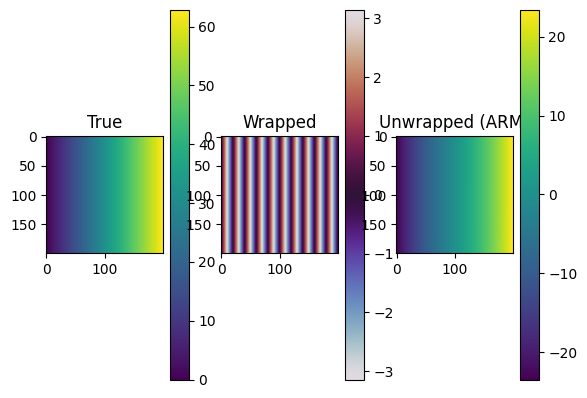

phi_unw shape: (200, 200)
phi_unw min/max: -23.447269053418314 23.385499380129534


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.ARM.unwrap_arm import unwrap_phase_ARM

rows, cols = 200, 200
x = np.linspace(0, 20*np.pi, cols)
true_phase = np.tile(x, (rows, 1))
wrapped = np.angle(np.exp(1j * true_phase))
mask = np.ones_like(wrapped, dtype=np.float64)

phi_unw = unwrap_phase_ARM(
    wrapped, mask=mask,
    mu=1.0, lam=0.001,
    nIter=10000, ban_OmegaInit=0
)
print(phi_unw.min(), phi_unw.max())



plt.subplot(1,3,1); plt.imshow(true_phase, cmap="viridis"); plt.title("True"); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(wrapped, cmap="twilight", vmin=-np.pi, vmax=np.pi); plt.title("Wrapped"); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(phi_unw, cmap="viridis"); plt.title("Unwrapped (ARM)"); plt.colorbar()
plt.show()

print("phi_unw shape:", phi_unw.shape)
print("phi_unw min/max:", phi_unw.min(), phi_unw.max())


NameError: name 'phi_unwrapped_ARM' is not defined

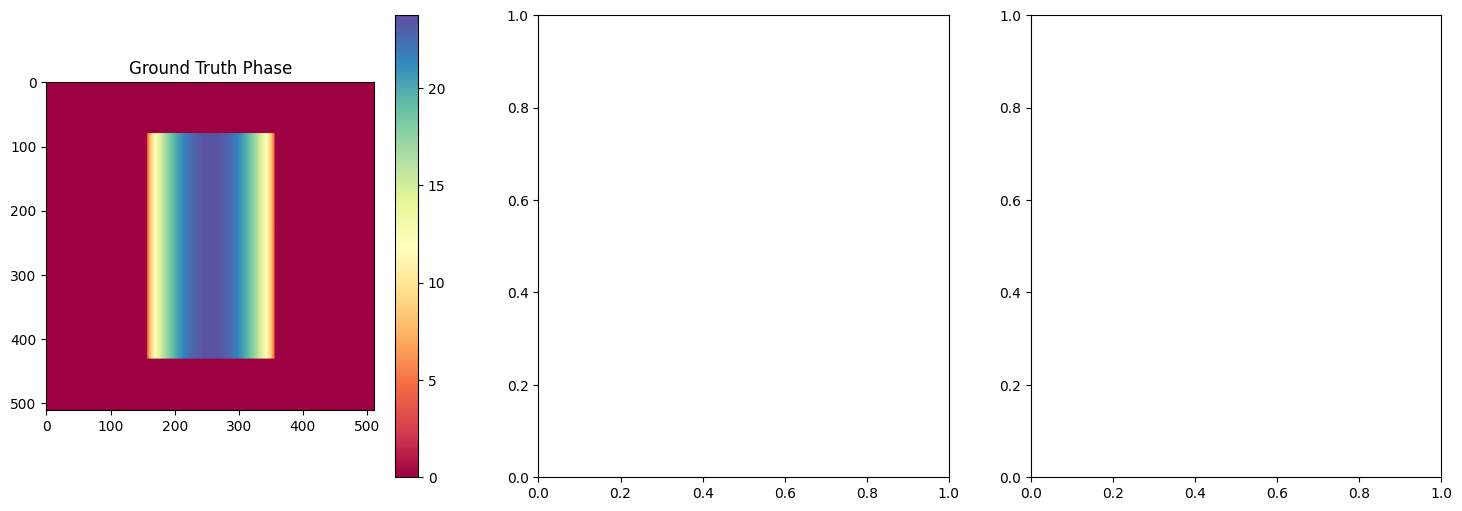

In [4]:
import matplotlib.pyplot as plt
from src.ARM.unwrap_arm import unwrap_phase_ARM

phi_unw = unwrap_phase_ARM(
    phi_wrapped_used,
    tissue_mask,
    mu=1.0, lam=0.005, nIter=12000, ban_OmegaInit=0
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth
im0 = axes[0].imshow(phi_true, cmap='Spectral')
axes[0].set_title("Ground Truth Phase")
plt.colorbar(im0, ax=axes[0])

# Unwrapped
im1 = axes[1].imshow(phi_unwrapped_ARM, cmap='Spectral')
axes[1].set_title("ARM Unwrapped Phase")
plt.colorbar(im1, ax=axes[1])

# Error
comp = phi_true - phi_unwrapped_ARM
im2 = axes[2].imshow(comp, cmap='bwr')
axes[2].set_title("Ground Truth – Unwrapped")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.ARM.unwrap_arm import unwrap_phase_ARM

# --- Inputs you already have ---
# phi_wrapped_used : 2D wrapped phase (radians)
# phi_true         : (optional) ground truth for visual check
# mask_cyl         : 1 inside cylinder, 0 outside (make this if you don't have one)

mask_cyl = np.ones_like(phi_wrapped_used, dtype=np.float64)  # replace with your cylinder mask if available

# Build a better initial guess F0
try:
    from skimage.restoration import unwrap_phase as sk_unwrap
    F0 = sk_unwrap(phi_wrapped_used)  # quick LS unwrap
except Exception:
    # simple phase integration along x as a fallback
    dx = np.unwrap(np.diff(phi_wrapped_used, axis=1), axis=1)
    F0 = np.cumsum(np.pad(dx, ((0,0),(1,0))), axis=1)

# Optional: remove global offset for nicer plots
F0 -= F0.mean()

# Run ARM with tuned params + our F0 and custom weights, and *freeze* Omegas from our iW/jW
phi_unw = unwrap_phase_ARM(
    phi_wrapped_used,
    mask=mask_cyl,
    mu=1.0,
    lam=0.005,       # try 0.001–0.02
    nIter=12000,     # 5k–15k for cylinders is normal
    ban_OmegaInit=1, # 1 = use our iW/jW once; try 0 as well
    F0=F0
)

# Plot quick check
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
im0 = axes[0].imshow(F0, cmap='Spectral'); axes[0].set_title("Initial guess F0"); plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(phi_unw, cmap='Spectral'); axes[1].set_title("ARM unwrapped"); plt.colorbar(im1, ax=axes[1])

comp = None
try:
    comp = phi_true - phi_unw
    im2 = axes[2].imshow(comp, cmap='bwr'); axes[2].set_title("Truth – Unwrapped"); plt.colorbar(im2, ax=axes[2])
except NameError:
    im2 = axes[2].imshow(phi_wrapped_used, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[2].set_title("Wrapped (reference)"); plt.colorbar(im2, ax=axes[2])

plt.tight_layout(); plt.show()


TypeError: unwrap_phase_ARM() got an unexpected keyword argument 'F0'